# Introduction

This notebook presents a method to train embedding layer using __Word2Vec Skip-Gram__ method on __Wikipedia text8__ dataset.

We are going to work with [text8](http://mattmahoney.net/dc/textdata) dataset. It is 100MB of cleaned English Wikipedia text. $\text{10MB} = 10^8$ hence text8

__Dataset:__
* [Large Text Compression Benchmark - About the test data](http://mattmahoney.net/dc/textdata) - download file named [text8.zip](http://mattmahoney.net/dc/text8.zip) and unzip it.

__References:__
* [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) - plain English tutorial on Skip-Grams
* [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781) - first skip-gram paper
* [Distributed Representations of Words and Phrases and their Compositionality](https://arxiv.org/abs/1310.4546) - follow up paper with improvements

# Imports

In [1]:
import time
import collections
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Read Data

Dataset location

In [6]:
dataset_location = '/home/marcin/Datasets/wiki-text8/text8'

In [11]:
with open(dataset_location, 'r') as f:
    text = f.read()
print(text[:500])

 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organization of society it has also been taken up as a positive label by self defined anarchists the word anarchism is derived from the greek without archons ruler chief king anarchism as a political philoso


Dataset is cleaned, it contains only lowercase letters and spaces

In [16]:
print(sorted(set(text)))

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [35]:
words_raw = text.split()
print(words_raw[:20])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english']


In [36]:
print('Total words:', len(words_raw))
print('Unique words:', len(set(words)))

Total words: 17005207
Unique words: 253854


# Preprocess the Data

First we will look at word-count distribution

In [51]:
words_counter = collections.Counter(words)
print('WORD : COUNT')
for w in list(words_counter)[:10]:
    print(w, ':', words_counter[w])

WORD : COUNT
anarchism : 303
originated : 572
as : 131815
a : 325873
term : 7219
of : 593677
abuse : 563
first : 28810
used : 22737
against : 8432


Lets plot word-counts on linear and logarithmic scales

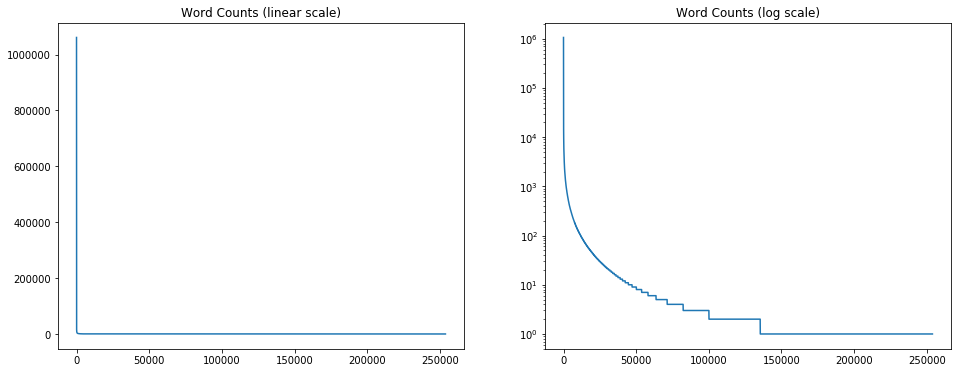

In [52]:
sorted_all = np.array(sorted(list(words_counter.values()), reverse=True))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=[16,6])
ax1.plot(sorted_all); ax1.set_title('Word Counts (linear scale)')
ax2.plot(sorted_all); ax2.set_title('Word Counts (log scale)')
ax2.set_yscale('log')

This is extremely sharp distribution. Some words appear over 1 million times, while over 100k words appear only once.

**Common Words**

Lets have a look at the most common words.

In [53]:
words_counter.most_common()[:10]

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644)]

We will deal with this later on using _subsampling_ as described by Mikolov.

**Rare Words**

Lets look at some of of the uncommon words

In [54]:
words_counter.most_common()[-10:]

[('kajn', 1),
 ('gorbacheva', 1),
 ('mikhailgorbachev', 1),
 ('englander', 1),
 ('workmans', 1),
 ('erniest', 1),
 ('metzada', 1),
 ('metzuda', 1),
 ('fretensis', 1),
 ('exortation', 1)]

Words like 'metzanda' or 'metzunda' are so rare (first ever time I see these) we are not concerned about them when building our NLP system. We will subsequently drop all words that 5 or less times.

In [57]:
list(enumerate(words_counter.most_common()[-10:]))

[(0, ('kajn', 1)),
 (1, ('gorbacheva', 1)),
 (2, ('mikhailgorbachev', 1)),
 (3, ('englander', 1)),
 (4, ('workmans', 1)),
 (5, ('erniest', 1)),
 (6, ('metzada', 1)),
 (7, ('metzuda', 1)),
 (8, ('fretensis', 1)),
 (9, ('exortation', 1))]

**Create dictionaries**

Tokenize words, but keep only ones that occur six or more times

In [79]:
i2w = {i : w for i, (w, c) in enumerate(words_counter.most_common()) if c > 5}
w2i = {w : i for i, w in i2w.items()}
print('Number of words after filter:', len(i2w))

Number of words after filter: 63641


Confirm both dictionaries check

In [78]:
for i in range(10):
    word = i2w[i]
    print(i, ':', word, ':', w2i[word])

0 : the : 0
1 : of : 1
2 : and : 2
3 : one : 3
4 : in : 4
5 : a : 5
6 : to : 6
7 : zero : 7
8 : nine : 8
9 : two : 9


**Tokenize**

In [85]:
data = [w2i[w] for w in words if w in w2i]
print('Number of tokens in dataset:', len(data))

Number of tokens in dataset: 16680599


This is our text, with uncommon words removed and converted to tokens:

In [86]:
print(data[:100])

[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580, 0, 194, 10, 190, 58, 4, 5, 10712, 214, 6, 1324, 104, 454, 19, 58, 2731, 362, 6, 3672, 0, 708, 1, 371, 26, 40, 36, 53, 539, 97, 11, 5, 1423, 2757, 18, 567, 686, 7088, 0, 247, 5233, 10, 1052, 27, 0, 320, 248, 44611, 2877, 792, 186, 5233, 11, 5, 200, 602, 10, 0, 1134, 19, 2621, 25, 8983, 2, 279, 31, 4147, 141, 59, 25, 6437]
